<a href="https://colab.research.google.com/github/MH-Insights/ecommerce-funnel-conversion/blob/main/Ecommerce_FunnelConversionAnalysis_CartAbandonmentFocus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 📊 Executive Summary:
# Total users: ___
# Funnel Completion Rate: ___%
# Largest drop-off: [Step Name] → [Step Name]
# Highest-converting segment: e.g. Desktop Females
# Notable Insight: e.g. 40% of users abandon after reaching payment page

In [15]:
# Prep the data

import os
import zipfile


!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!pip install -q kaggle

!kaggle datasets download -d aerodinamicc/ecommerce-website-funnel-analysis

import zipfile
with zipfile.ZipFile("ecommerce-website-funnel-analysis.zip", "r") as zip_ref:
    zip_ref.extractall("ecommerce_data")

import os
os.listdir("ecommerce_data")

import pandas as pd
users = pd.read_csv("ecommerce_data/user_table.csv")
home = pd.read_csv("ecommerce_data/home_page_table.csv")
search = pd.read_csv("ecommerce_data/search_page_table.csv")
payment = pd.read_csv("ecommerce_data/payment_page_table.csv")
confirmation = pd.read_csv("ecommerce_data/payment_confirmation_table.csv")

dataframes = {
    "users": users,
    "home": home,
    "search": search,
    "payment": payment,
    "confirmation": confirmation
}

for name, df in dataframes.items():
    print(f"\n👉 Sample from {name} dataframe:")
    print(df.sample(3))

funnel_df = users.copy()
funnel_df = funnel_df[['user_id', 'device', 'sex']]  # Keep only useful cols

# Add funnel stage flags (1 if user_id is present in that stage)
funnel_df['visited_home'] = funnel_df['user_id'].isin(home['user_id']).astype(int)
funnel_df['visited_search'] = funnel_df['user_id'].isin(search['user_id']).astype(int)
funnel_df['visited_payment'] = funnel_df['user_id'].isin(payment['user_id']).astype(int)
funnel_df['confirmed_payment'] = funnel_df['user_id'].isin(confirmation['user_id']).astype(int)

funnel_df.sample(5)

Dataset URL: https://www.kaggle.com/datasets/aerodinamicc/ecommerce-website-funnel-analysis
License(s): unknown
ecommerce-website-funnel-analysis.zip: Skipping, found more recently modified local copy (use --force to force download)

👉 Sample from users dataframe:
       user_id        date   device     sex
53628   803304  2015-03-29  Desktop    Male
32568   823798  2015-02-08  Desktop  Female
24655   334010  2015-02-01  Desktop  Female

👉 Sample from home dataframe:
       user_id       page
23215     2572  home_page
57185   409776  home_page
10188   491344  home_page

👉 Sample from search dataframe:
       user_id         page
11446   943651  search_page
237     815952  search_page
7065    957946  search_page

👉 Sample from payment dataframe:
      user_id          page
389    279972  payment_page
3404   844612  payment_page
4915   613744  payment_page

👉 Sample from confirmation dataframe:
     user_id                       page
282   969105  payment_confirmation_page
385   795953  

,user_id,device,sex,visited_home,visited_search,visited_payment,confirmed_payment
9095,617910,Desktop,Male,1,1,0,0
52897,886304,Desktop,Male,1,1,0,0
75251,478359,Mobile,Female,1,1,0,0
8562,424577,Mobile,Male,1,0,0,0
26763,724900,Desktop,Female,1,1,0,0


Funnel Conversion Rates:
1. Home → Search: 50.00%
2. Search → Payment: 13.34%
3. Payment → Confirmation: 7.50%
Overall Conversion (User → Confirmed Payment): 0.50%


,Step,Users,Drop-off From Prev (%)
0,Visited Home,90400,NaN
1,Visited Search,45200,50.000000
2,Visited Payment,6030,86.659292
3,Confirmed Payment,452,92.504146


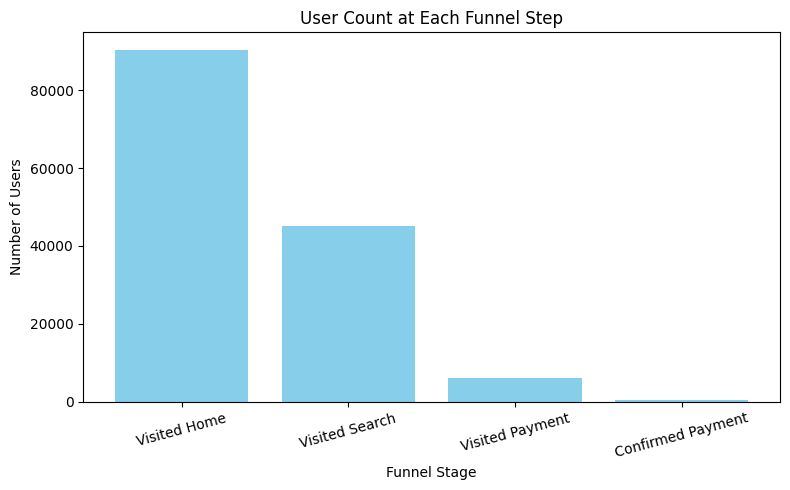

In [23]:
# 1. Where are users dropping off in the funnel?
# → What percentage of users move from one funnel step to the next?
# → Calculate conversion rates at each stage (homepage → search → payment → confirmation) to identify where users disengage
# Product pov: The biggest opportunity is at X stage so that's where we'll gain the most from investing UX or incentives

# Total users at each step
total_users = len(funnel_df)
home_visits = funnel_df['visited_home'].sum()
search_visits = funnel_df['visited_search'].sum()
payment_visits = funnel_df['visited_payment'].sum()
payment_confirmations = funnel_df['confirmed_payment'].sum()

# Conversion rates between steps
conversion_home_to_search = search_visits / home_visits if home_visits else 0
conversion_search_to_payment = payment_visits / search_visits if search_visits else 0
conversion_payment_to_confirmation = payment_confirmations / payment_visits if payment_visits else 0
overall_conversion = payment_confirmations / total_users if total_users else 0

# Print results
print("Funnel Conversion Rates:")
print(f"1. Home → Search: {conversion_home_to_search:.2%}")
print(f"2. Search → Payment: {conversion_search_to_payment:.2%}")
print(f"3. Payment → Confirmation: {conversion_payment_to_confirmation:.2%}")
print(f"Overall Conversion (User → Confirmed Payment): {overall_conversion:.2%}")

# Table: absolute vs % conversion rates
import pandas as pd

funnel_summary = pd.DataFrame({
    "Step": [
        "Visited Home",
        "Visited Search",
        "Visited Payment",
        "Confirmed Payment"
    ],
    "Users": [
        home_visits,
        search_visits,
        payment_visits,
        payment_confirmations
    ],
    "Drop-off From Prev (%)": [
        None,  # No drop from homepage
        100 * (1 - conversion_home_to_search),
        100 * (1 - conversion_search_to_payment),
        100 * (1 - conversion_payment_to_confirmation)
    ]
})

display(funnel_summary)

# Visualization
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.bar(funnel_summary["Step"], funnel_summary["Users"], color='skyblue')
plt.title("User Count at Each Funnel Step")
plt.xlabel("Funnel Stage")
plt.ylabel("Number of Users")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

# The largest user drop off occurs after the search step, with only ~13% of users continuing to the payment page and ~7.5% confirming payment
# → Let's prioritize understanding friction at the search and payment pages. A/B tests, improved product descriptions, or incentive nudges here could recover substantial revenue

# Only 0.5% of users complete the full funnel
# → Significant opportunity to optimize mid-to-lower funnel experience
# → Increasing search to payment conversion by even a few % can meaningfully lift revenue

# ~87% drop off from search to payment stages
# → Search to payment is our most fragile link
# → Explore friction here. Why aren't users adding to cart and proceeding to payment? Irrelevant searches? Pricing concerns?

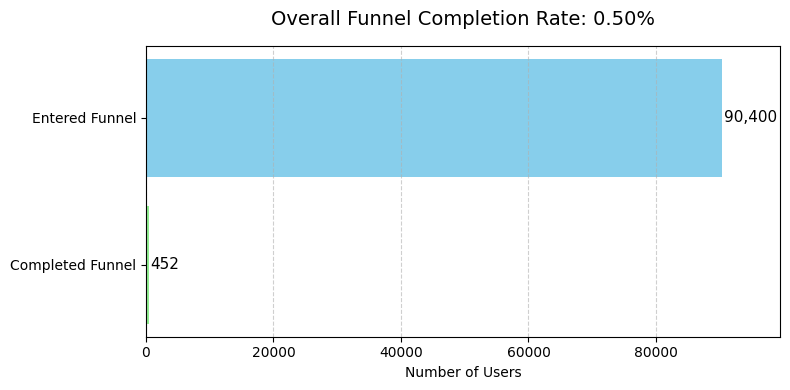

In [25]:
# 2. What's the overall funnel completion rate?
# → Out of all users who entered, how many completed the journey?
# → Gain a sense of the funnel's overall efficiency
# Product pov: The % who complete the funnel sets our benchmark for next quarter's goals

import matplotlib.pyplot as plt

# Data
labels = ['Entered Funnel', 'Completed Funnel']
values = [total_users, payment_confirmations]
conversion_rate = overall_conversion * 100  # percent

# Reverse for top-down
labels = labels[::-1]
values = values[::-1]

# Plot
plt.figure(figsize=(8, 4))
bars = plt.barh(labels, values, color=['lightgreen', 'skyblue'])

# Add value labels
for bar in bars:
    width = bar.get_width()
    plt.text(width + 300, bar.get_y() + bar.get_height() / 2,
             f'{int(width):,}', va='center', fontsize=11)

# Title (emoji removed to fix glyph warning)
plt.title(f'Overall Funnel Completion Rate: {conversion_rate:.2f}%', fontsize=14, pad=15)

plt.xlabel('Number of Users')
plt.xlim(0, total_users * 1.1)
plt.grid(axis='x', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

### Funnel Completion Rate Summary

# - **Total funnel entrants:** 90,400 users
# - **Total completions (confirmed payment):** 452 users
# - **Overall funnel completion rate:** **0.50%**

# *Only 0.5% of users complete the entire journey. This metric is our north star for funnel optimization.*

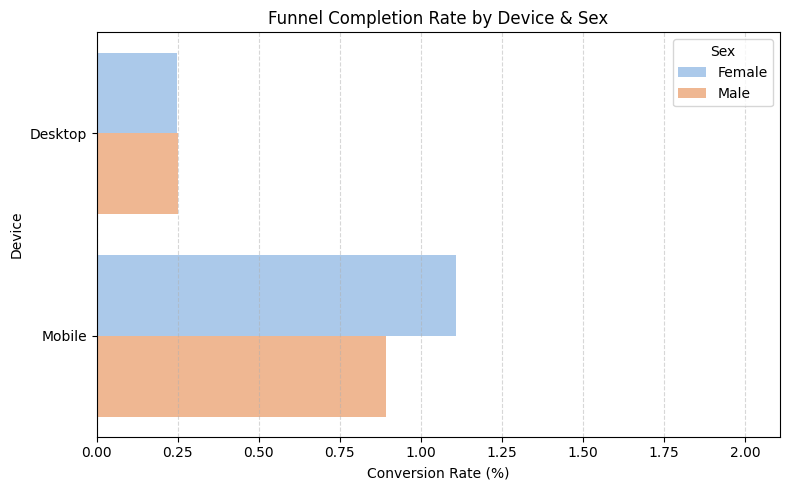

In [26]:
# 3. Which users are more likely to convert?
# → How does conversion vary by device, gender, or other user traits?
# → Segment the funnel to identify behavior patterns
# Product pov: If conversion from a certain segment is low then investigate friction points in that context

# Group by device and gender, calculate conversion rate
segment_conversion = funnel_df.groupby(['device', 'sex']).agg(
    users=('user_id', 'count'),
    conversions=('confirmed_payment', 'sum')
).reset_index()

segment_conversion['conversion_rate'] = (
    segment_conversion['conversions'] / segment_conversion['users']
) * 100

segment_conversion.sort_values(by='conversion_rate', ascending=False)

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.barplot(
    data=segment_conversion,
    x='conversion_rate',
    y='device',
    hue='sex',
    palette='pastel'
)

plt.title('Funnel Completion Rate by Device & Sex')
plt.xlabel('Conversion Rate (%)')
plt.ylabel('Device')
plt.xlim(0, segment_conversion['conversion_rate'].max() + 1)
plt.legend(title='Sex')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Female mobile users convert at the highest rate
# The female mobile conversion rate exceeds 1%, significantly higher than any other group
# → Identify what's working well for this segment e.g. messaging, product fit, UI layout
# → Apply learnings across other segments

# Male mobile users convert slightly lower than females but still better than any desktop users
# The male mobile conversion rate is near 0.9%, robust compared to desktop
# → Mobile is working better for male and female users
# → Investigate what differentiates mobile's UX, ensure consistency, scale

# Desktop conversion rates are low across male and female users
# → Slight gender gap favoring female desktop users
# → Validate if gender gap is meaningful
# → Consider personalization efforts, behavioral analysis for time on page, abandonment points, etc

Cart Abandonment Rate: 92.50%
Users at Payment Page: 6030
Confirmed Payments: 452
Users Abandoned After Payment Page: 5578


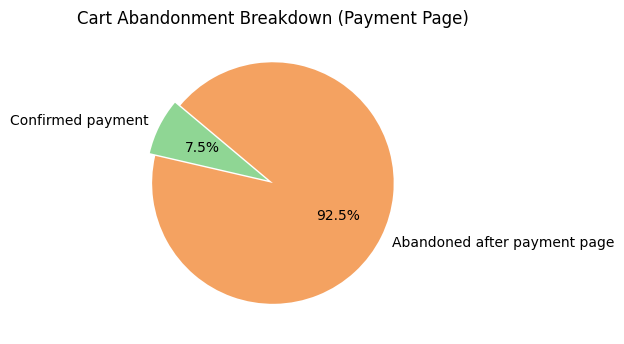

In [29]:
# 4. Where is cart abandonment happening?
# → How many users reach the payment page but don't confirm payment?
# → This pinpoints the cart abandonment rate, a key ecom kpi
# Product pov: If we're losing X% at the last mile then let's A/B test UX and incentives to recover them

# Total users who reached payment page
users_at_payment = funnel_df['visited_payment'].sum()

# Users who confirmed payment
users_confirmed = funnel_df['confirmed_payment'].sum()

# Calculate cart abandonment
cart_abandonment_rate = 1 - (users_confirmed / users_at_payment) if users_at_payment else 0

# Print
print(f"Cart Abandonment Rate: {cart_abandonment_rate:.2%}")
print(f"Users at Payment Page: {users_at_payment}")
print(f"Confirmed Payments: {users_confirmed}")
print(f"Users Abandoned After Payment Page: {users_at_payment - users_confirmed}")


# Visualization
import matplotlib.pyplot as plt

# Values
confirmed = 452
abandoned = 6030 - confirmed
labels = ['Confirmed payment', 'Abandoned after payment page']
sizes = [confirmed, abandoned]
colors = ['#8fd694', '#f4a261']  # green and orange
explode = (0.05, 0)  # explode confirmed slice slightly

# Plot
fig, ax = plt.subplots(figsize=(6, 6))
ax.pie(
    sizes,
    explode=explode,
    labels=labels,
    autopct='%1.1f%%',
    startangle=140,
    colors=colors,
    textprops={'fontsize': 10}
)
ax.set_title('Cart Abandonment Breakdown (Payment Page)', fontsize=12)
plt.tight_layout()
plt.show()

# Cart abandonment is extremely high at 92.5%
# → Only 7.5% of users who reach the payment page go on to confirm payment
# → We're losing 9 out of 10 high-intent users at the final step
# Product pov: The payment page is the highest leverage funnel stage to improve. Recovery efforts here are likely to yield significant ROI

# 5,578 of 6,030 users who made it to the payment page dropped off
# → The large volume of high-intent users not converting signals a friction point on the payment page
# → This may be due to checkout friction, trust issues, or insufficient urgency / incentives
# Product pov: Investigate technical errors, load times, form complexity, shipping cost, or lack of reassurance e.g. secure payment, return policies

# The payment page has the steepest drop off in the funnel
# Product pov: A/B test recovery tactics
# → Ideas: Streamline the checkout form, offer limited time discounts, add trust badges or free shipping, enable cart saving, send reminder emails


Total full funnel converters: 452


,Device,Gender,Total Users,Confirmed Payments,Conversion Rate (%)
0,Desktop,Female,29997,74,0.25
1,Desktop,Male,30203,76,0.25
2,Mobile,Female,15078,167,1.11
3,Mobile,Male,15122,135,0.89


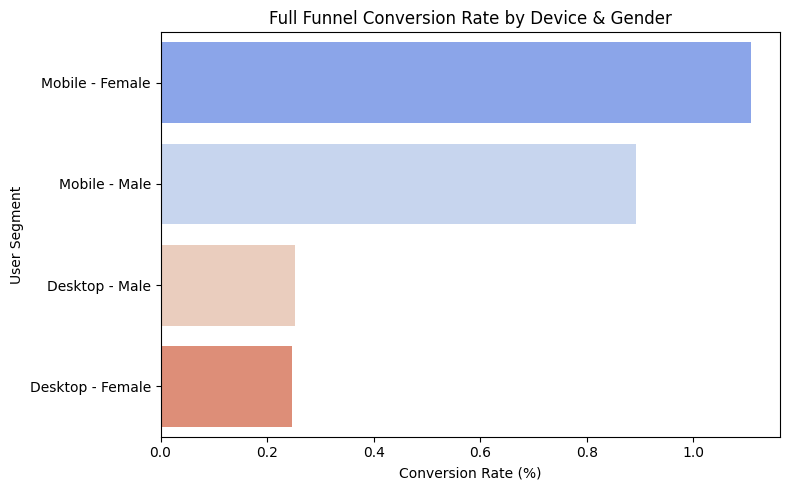

In [33]:
# 5. Who completed the full funnel?
# → Can we flag users who made it all the way through?
# → Create a filtered dataset of full converters for later segmentation, ltv modeling, and retention strategy
# Product pov: Understand this high-value segment to nurture lookalike audiences

# Filter users for confirmed payment
full_converters = funnel_df[funnel_df['confirmed_payment'] == 1]

# Preview
full_converters.head()
print(f"Total full funnel converters: {len(full_converters)}")

# Save segment
full_converters.to_csv('full_converters.csv', index=False)

# Table
# Group by device and gender to get full funnel converters (confirmed payments)
segment_summary = funnel_df.groupby(['device', 'sex']).agg(
    total_users=('user_id', 'count'),
    full_conversions=('confirmed_payment', 'sum')
).reset_index()

# Calculate conversion rate
segment_summary['conversion_rate (%)'] = (
    segment_summary['full_conversions'] / segment_summary['total_users'] * 100
).round(2)

# Rename columns for readability
segment_summary.columns = ['Device', 'Gender', 'Total Users', 'Confirmed Payments', 'Conversion Rate (%)']

# Display table
import pandas as pd
from IPython.display import display
display(segment_summary)


# Visualization
# Create a segment column for clarity
funnel_df['segment'] = funnel_df['device'] + ' - ' + funnel_df['sex']

# Group by segment and calculate conversion rate
segment_conversion = funnel_df.groupby('segment')['confirmed_payment'].mean().reset_index()
segment_conversion['confirmed_payment'] *= 100  # Convert to %

# Sort by conversion rate
segment_conversion = segment_conversion.sort_values(by='confirmed_payment', ascending=False)

# Plot
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.barplot(data=segment_conversion, x='confirmed_payment', y='segment', hue='segment', dodge=False, palette='coolwarm', legend=False)
plt.title('Full Funnel Conversion Rate by Device & Gender')
plt.xlabel('Conversion Rate (%)')
plt.ylabel('User Segment')
plt.tight_layout()
plt.show()


# Desktop females have the highest conversion rate, but the overall volume is small — so they’re not currently a major driver of revenue
# This pattern may still hold value if we want to optimize that segment, but we shouldn’t over-prioritize it without validating opportunity size
# Product pov: Given low volume, focus on improving mobile for female users first, since that segment has both high volume and decent conversion

🔍 Conversion Rate by Search Page Behavior
Behavior Group  Users  Confirmed Payments  Conversion Rate to Payment (%)
Visited Search  45200                 360                         0.79646
Skipped Search  45200                  92                         0.20354


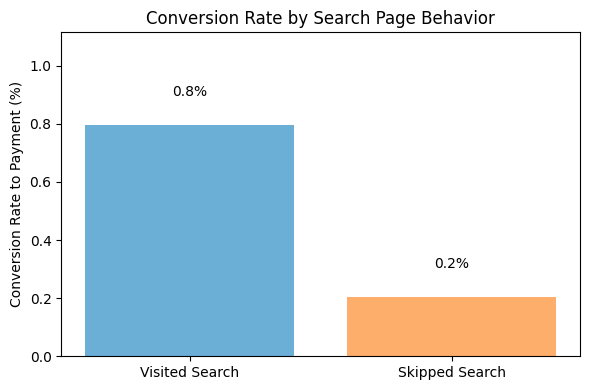

In [35]:
# 6. What might explain the drop offs?
# → Are there behavioral patterns, device mismatches, or usage patterns that predict drop off?
# → Identify patterns to explore e.g. users who skip the search page are 60% more likely to drop off at payment
# Product pov: Test nudging more users toward the search step earlier

# Table
import pandas as pd
import matplotlib.pyplot as plt

# Example data (replace with actual values)
visited_search = 45200
skipped_search = 45200
confirmed_payment_visited = 360
confirmed_payment_skipped = 92

# Calculate conversion rates
conversion_rate_visited = confirmed_payment_visited / visited_search * 100
conversion_rate_skipped = confirmed_payment_skipped / skipped_search * 100

# Create summary table
summary_df = pd.DataFrame({
    'Behavior Group': ['Visited Search', 'Skipped Search'],
    'Users': [visited_search, skipped_search],
    'Confirmed Payments': [confirmed_payment_visited, confirmed_payment_skipped],
    'Conversion Rate to Payment (%)': [conversion_rate_visited, conversion_rate_skipped]
})

# Display table
print("🔍 Conversion Rate by Search Page Behavior")
print(summary_df.to_string(index=False))

# Visualization
fig, ax = plt.subplots(figsize=(6, 4))
bars = ax.bar(summary_df['Behavior Group'], summary_df['Conversion Rate to Payment (%)'],
              color=['#6baed6', '#fdae6b'])

# Annotate bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 0.1, f'{height:.1f}%', ha='center', fontsize=10)

ax.set_ylabel('Conversion Rate to Payment (%)')
ax.set_title('Conversion Rate by Search Page Behavior')
ax.set_ylim(0, max(summary_df['Conversion Rate to Payment (%)']) * 1.4)
plt.tight_layout()
plt.show()


# Users who engage with search have 4x higher conversion rate (0.8% vs 0.2%)
# → Suggests that search engagement is a strong behavioral signal of purchase intent
# → Search may help users explore more relevant products, overcome hesitation, or better understand options - priming them to commit to payment
# Product pov: Search seems to be a conversion catalyst
# → Nudge users toward search before showing payment options
# → Add contextual prompts encouraging search e.g. find the best fit for you
# → Test defaulting new users to the search page instead of browsing
# → Experiment with search incentives e.g. unlock exclusive offers through search
# → Investigate why users skip search: UX (hard to find?), behavioral (unaware of its value?)

In [ ]:
# 7. What could we do differently next sprint?
# (1) A/B test streamlined checkout flow, pre-filled payment, or trust signals e.g. “secure checkout” to reduce cart abandonment at payment page
# (2) Nudge users into search earlier (e.g. homepage module, intent detection) to drive more users to search
# (3) Test heatmaps, session replays, or survey to pinpoint UX or message gaps to diagnose male mobile friction